## Part II. Environment and dataset

In [2]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.lines as mlines
import sys
print(sys.version)
import seaborn as sns



3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]


In [3]:
dfnew = pd.read_csv("transcript_annotation_rf.csv", delimiter=',', sep=r', ') 
dfnew = pd.get_dummies(dfnew, columns=["presence_term", "localization", "essentiality", "COG_category"])

# keep only CDS with good correlation and positive half life
dfnew2 = dfnew[(dfnew['type']=='mRNA') & (dfnew["r_squaredCDS"] >= 0.75) & (dfnew["half_lifeCDS"]>0)].copy()
features2select = ['ORF', 'GC_content',
                   'first_energy3', 'last_energy3',
                   'coverage', 'fiveUTR_length', 'transcript_length', 'first_riboseq1',

                   'half_lifeCDS', 'hf_category2']  # The two last are the dependent values
dfnew2 = dfnew2[features2select]
dfnew2.set_index('ORF', inplace=True)
dfnew2 = dfnew2[~dfnew2.isna().any(axis=1)]
#df1 = dfnew2[dfnew2.isna().any(axis=1)]


In [4]:
# Rational selection of features
X = dfnew2[list(dfnew2.columns)[:-2]].copy()

# Predictables
#y = list(dfnew2['half_lifeCDS'])
y = list(dfnew2['hf_category2']) 
#y_cat2 = np.array([0 if i<=np.median(y) else 1 for i in y]) # 2 categories classification (using the median as threshold between categories)
#y_cat3 = LabelBinarizer().fit_transform(y_cat)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 47, stratify = y)

In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10000,max_depth=7)
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, n_estimators=10000)

In [8]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Step 4. Evaluate the predictor


In [219]:
# Measuring the accuracy of our model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, model.predict(X_test))*100
print(accuracy)

54.347826086956516


In [11]:
from sklearn import metrics

metrics.plot_roc_curve(model, X_train, y_train)
plt.show()       
#metrics.plot_roc_curve(model, X_test, y_test)
#plt.show()       

ValueError: RandomForestClassifier should be a binary classifier

**EXERCISE**: Do you remember how to interpret these graphics? What does AUC mean? What are the differences between? Which model is better considering

In [23]:
accuracies=[]
for i in model.estimators_:
  accuracies.append(accuracy_score(y_test, i.predict(X_test)))

In [24]:
accuracies.index(min(accuracies))

0

(array([    0.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

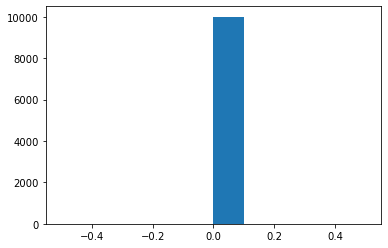

In [25]:
plt.hist(accuracies)

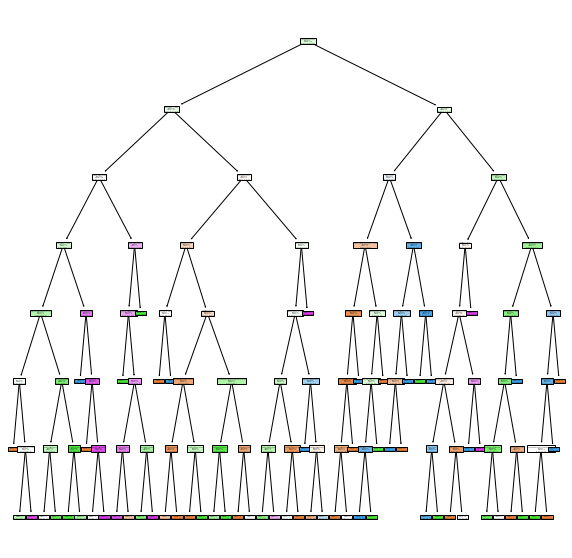

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

onetree = model.estimators_[6]
plt.figure(figsize=(10,10))
tree.plot_tree(onetree,
               feature_names = X.columns,
               filled = True)
plt.show()

Now model is a **predictor** that can be asked about the probability of a Pokemon to be legendary based in a list of stats:

In [33]:
def extract_feats_by_name(pokemon_name):
    """ Function to extract features from pokemon names """
    if pokemon_name in set(dataset['Name']):
        feats = np.array(np.array(dataset[dataset['Name']==pokemon_name])[0][2:-1])
        feats = feats.reshape(1, -1)
        return feats
    else:
        print(pokemon_name, 'not in dataset.')
        


array([ True])

In [35]:
model.predict(extract_feats_by_name('Mewtwo'))

array([ True])

In [36]:
model.predict(extract_feats_by_name('Charizard')) # This is the label expected 

array([False])

In [38]:
model.predict_proba(extract_feats_by_name('Charizard')) # These are the probabilities for each class

array([[0.70480899, 0.29519101]])

### Step 5. Feature importance

Due to the greedy nature of Decision Trees, they are able to highlight which features are important deciding factors when classifying, this is known as feature selection.

This will help us understand what features are relatively important in deciding what makes a Pokémon legendary.

Sk-learn has a neat feature called feature_importances_which can measure a feature’s importance by looking at how much that feature reduces entropy in the forest on average. It scales the results so that the sum of all importances is equal to 1.

The features which scored the highest are shown below.

In [25]:
importances = {feature:importance*100 for feature, importance in zip(X.columns, model.feature_importances_)}
importances = pd.DataFrame.from_dict(importances, orient='index')
importances.columns = ['Importance']
importances.sort_values(by='Importance', ascending=False)

,Importance
rnase3_downreg,6.798332
transcript_length,6.402080
GC_content,5.461167
fiveUTR_length,4.821756
first_energy3,4.567992
last_energy3,4.386406
gene_level_avg_ribo_density_scaled,4.297219
last_energy5,4.275341
first_energy1,4.260543
CAI_index,4.211518


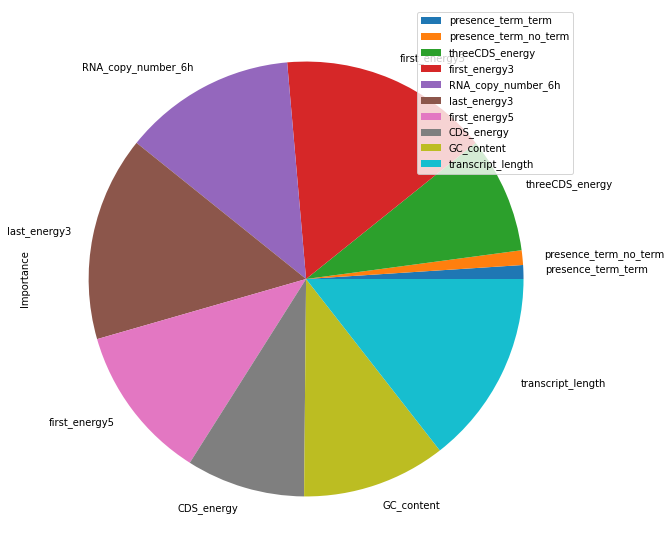

In [558]:
# more graphical
plot = importances.plot.pie(y='Importance', figsize=(10, 10))

Interestingly enough, it appears that the most decisive feature is Total (the total sum of all base stats).

Legendary Pokémon are generally known to be more powerful than normal Pokémon, so it makes sense that the Total attribute would be a big indicator of legendary status.

Also, we can see there is a quick decline in importance value from Total to lesser important features. This shows us that certain features such as the Types are not actually giving us much information in identifying legendary Pokemon. (Type 1_Bug only reduces entropy 0.6% of the time!). These means this features could be not taken into account and they can possibly be removed from our data set as they’re just noise.

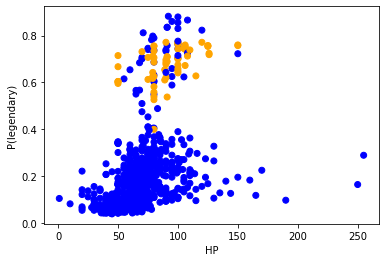

In [42]:
# Plot relating the probability to be legendary with some of the features:
probs = []
feat = 'HP'
feature = list(dataset[feat])
for pokemon in list(dataset['Name']):
    probs.append(model.predict_proba(extract_feats_by_name(pokemon))[0][1])
plt.scatter(feature, probs, color=['orange' if i else 'blue' for i in y])
plt.xlabel(feat)
plt.ylabel('P(legendary)')
plt.show()

## Part V. Discussion and conclusions

- Do you think these methods are useful? 
- Can you come up with a clinical example where this could be used? 
